In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 8, 5

from statsmodels.tsa import arima_model

from sklearn.linear_model import LinearRegression

from importlib import reload
import os

import funcs

funcs = reload(funcs)

In [2]:
train_data = pd.read_csv(os.path.join('data', 'ts_train.csv'))
test_data = pd.read_csv('data/ts_test.csv')

In [3]:
train_data.head()

,ID,Date,tsID,ACTUAL,Temp,Saturday,Sunday
0,15672,01.01.2010,1,90468.0,22.5,0.0,1
1,15673,02.01.2010,1,92764.0,20.0,1.0,0
2,15674,03.01.2010,1,94791.0,21.0,0.0,1
3,15675,04.01.2010,1,98010.0,16.8,0.0,1
4,15676,05.01.2010,1,100975.0,19.2,0.0,1


In [4]:
train_size = 0.6
valid_size = 0.4 # ~

indices = np.arange(len(train_data))

train = []
valid = []

for i in train_data.tsID.unique():
    indices = np.where(train_data.tsID == i)[0]
    size = int(len(indices) * train_size)
    
    train.append(train_data.iloc[indices][:size].copy())
    valid.append(train_data.iloc[indices][size:].copy())
    
train = pd.concat(train)
valid = pd.concat(valid)

In [5]:
def select_ts(index):
    return (train_data[train_data.tsID == index].copy(),
            test_data[test_data.tsID == index].copy())

In [6]:
def select_valid(index):
    return (train[train.tsID == index].copy(),
            valid[valid.tsID == index].copy())

def select_test(index):
    return (train_data[train_data.tsID == index].copy(),
            test_data[test_data.tsID == index].copy())

### Plots

How connected is temp and actual

Time series 1


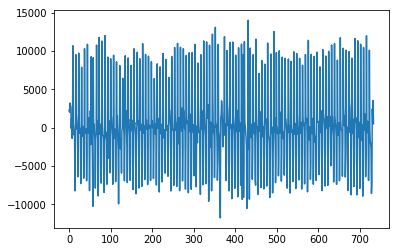

Time series 2


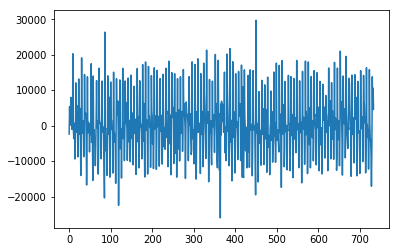

Time series 3


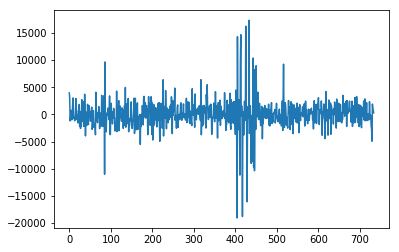

Time series 4


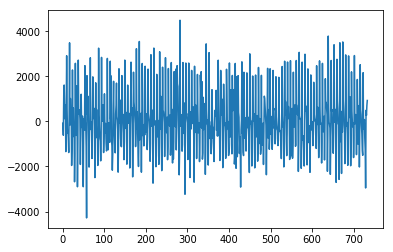

Time series 5


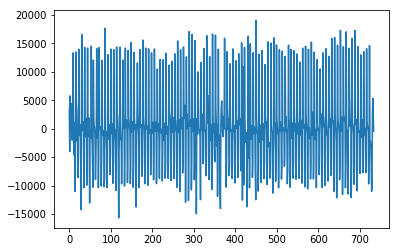

Time series 6


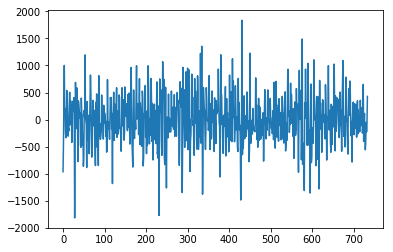

Time series 7


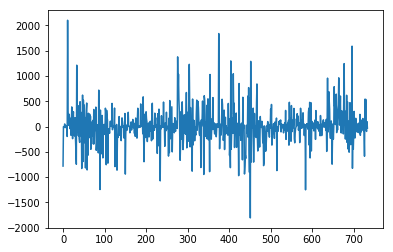

Time series 8


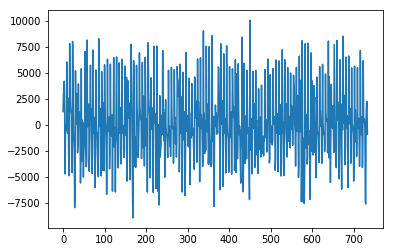

Time series 9


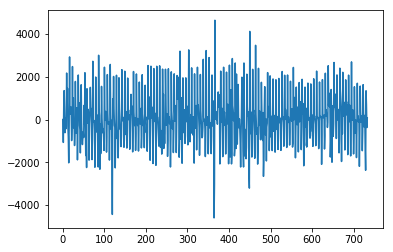

Time series 10


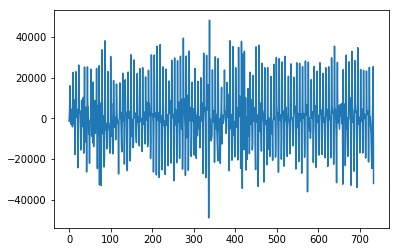

Time series 11


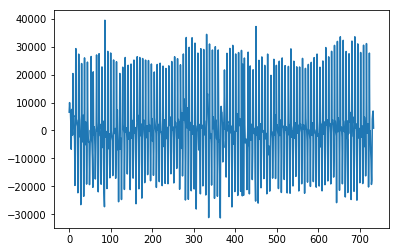

Time series 12


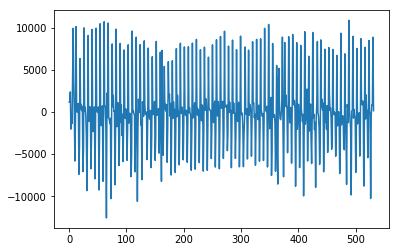

Time series 13


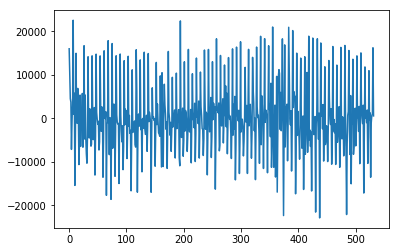

Time series 14


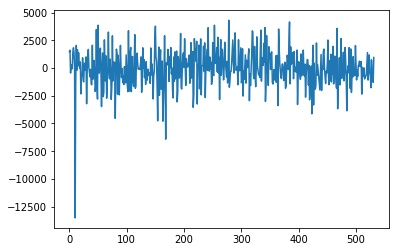

Time series 15


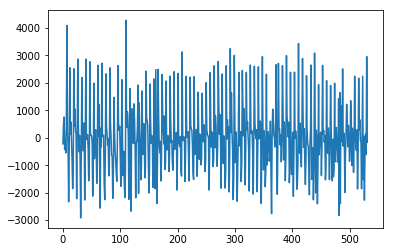

Time series 16


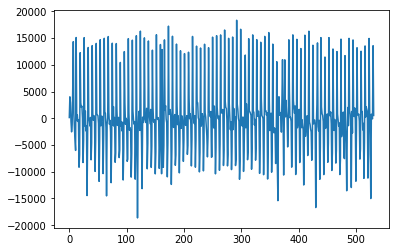

Time series 17


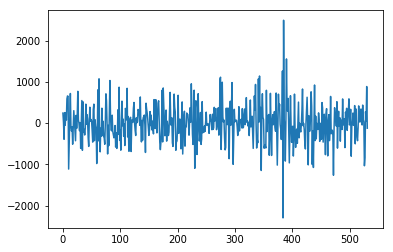

Time series 18


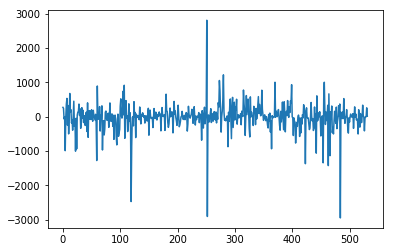

Time series 19


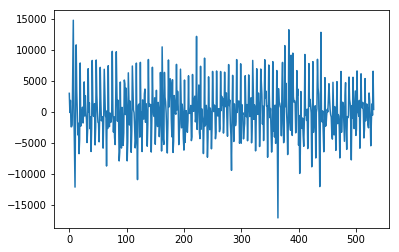

Time series 20


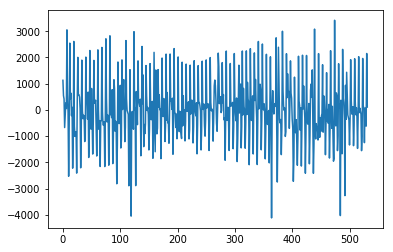

Time series 21


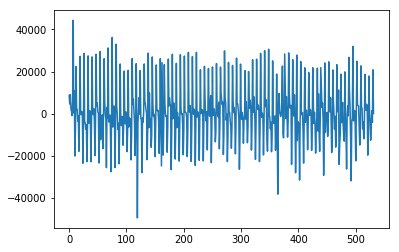

Time series 22


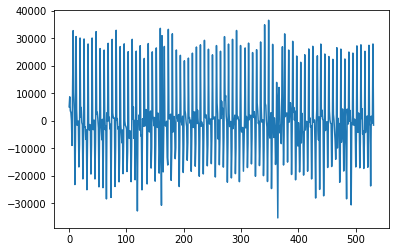

In [7]:
for i in train_data.tsID.unique():
    print(f"Time series {i}")
    plt.plot(np.diff(select_ts(i)[0].ACTUAL.values))
    plt.show()

Time series 1


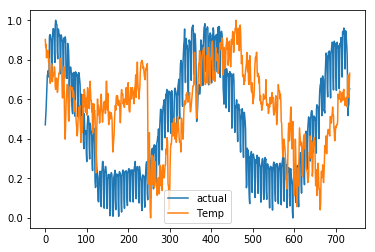

Time series 2


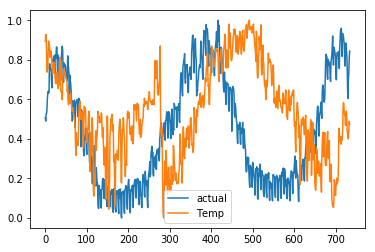

Time series 3


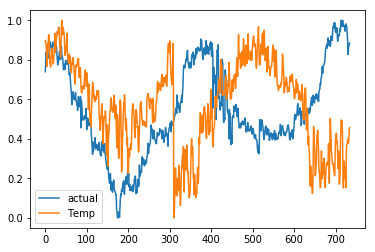

Time series 4


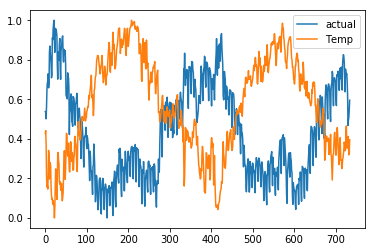

Time series 5


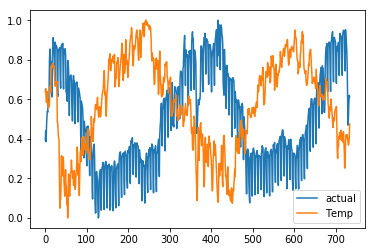

Time series 6


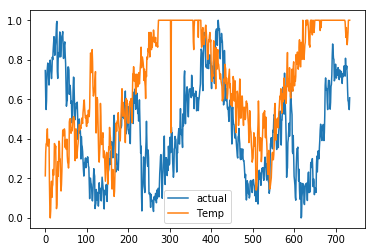

Time series 7


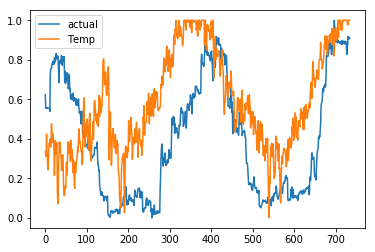

Time series 8


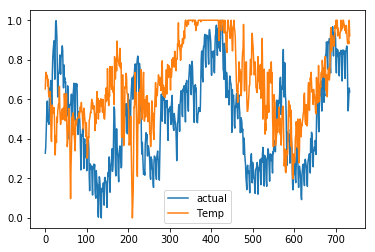

Time series 9


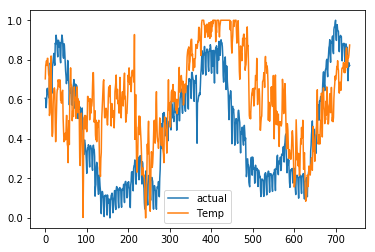

Time series 10


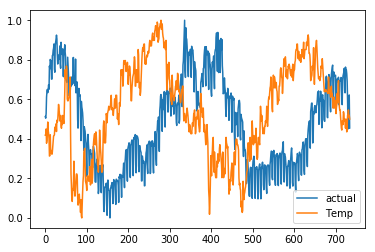

Time series 11


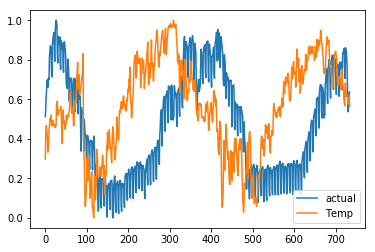

Time series 12


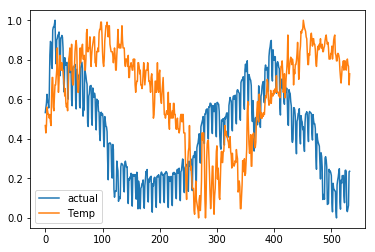

Time series 13


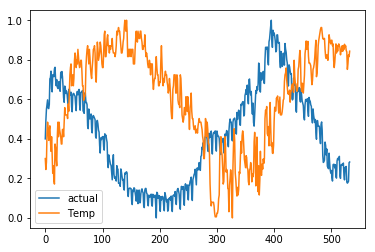

Time series 14


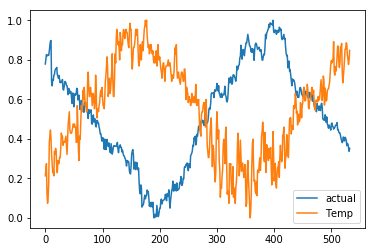

Time series 15


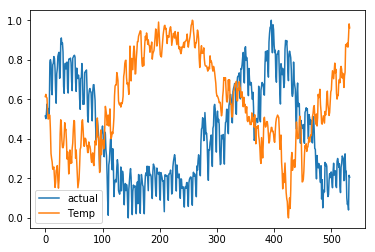

Time series 16


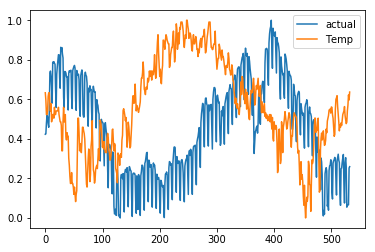

Time series 17


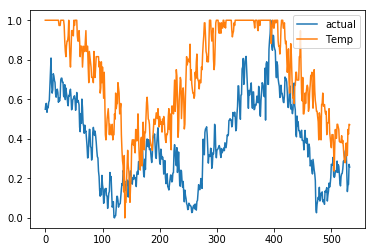

Time series 18


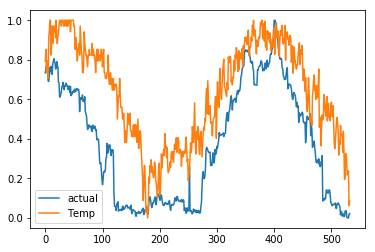

Time series 19


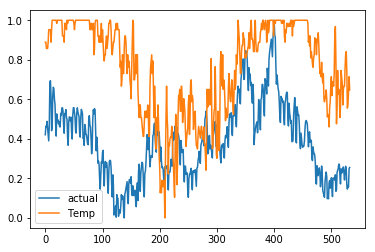

Time series 20


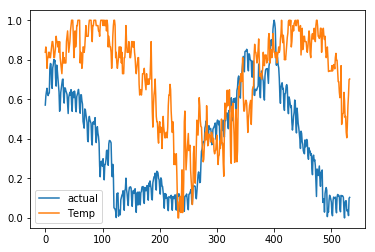

Time series 21


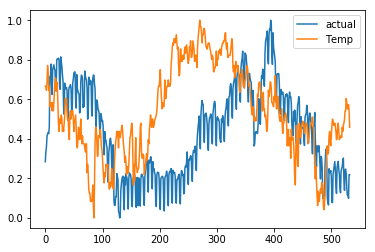

Time series 22


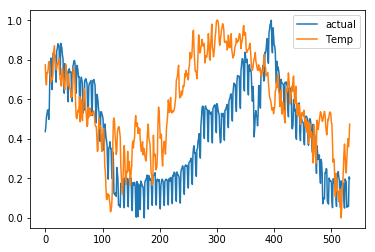

In [8]:
for i in train_data.tsID.unique():
    print(f"Time series {i}")
    # normalize
    actual = select_ts(i)[0].ACTUAL.values
    temp = select_ts(i)[0].Temp.values
    z1 = (actual - np.min(actual)) / (np.max(actual) - np.min(actual))
    z2 = (temp - np.min(temp)) / (np.max(temp) - np.min(temp))
    plt.plot(z1)
    plt.plot(z2)
    plt.legend(["actual", "Temp"])
    plt.show()

Stat models *ma*

In [30]:
def prepare(data, d):
    train_matrix = []
    test_vector = []

    for i in range(d, len(data)):
        train_matrix.append(data[i-d:i])
        test_vector.append(data[i])
    return np.array(train_matrix), np.array(test_vector)

In [93]:
def estimate_linear_reg(train, test, d):
    M, Y = prepare(train.Temp.values, d)
    model = LinearRegression()
    model.fit(M, Y)

    x = train.Temp.values[-d:]
    y = []

    for _ in range(len(test)):
        p = model.predict(x.reshape(1, -1))
        y.append(p[0])
        x = np.hstack((x[1:], p))
    test["ACTUAL"] = y
    return test

In [86]:
v_pred = []
v_actual = []

for ts_id in train.tsID.unique():
    tr, val = select_valid(ts_id)
    arima = arima_model.ARIMA(tr.ACTUAL.values, order=(2, 0, 3))
    arima_fit = arima.fit()
    pred = arima_fit.predict(len(tr), len(tr) + len(val))

    v_pred.append(pred)
    v_actual.append(val.ACTUAL.values)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
for pred, i in zip(v_pred, train_data.tsID.unique()):
    print(f"Time series {i}")
    # normalize
    actual = select_ts(i)[0].ACTUAL.values
    plt.plot(actual)
    plt.plot(pred)
    plt.legend(["actual", "Temp"])
    plt.show()

In [70]:
np.mean([funcs.mape(pred[-len(actual):], actual) for pred, actual in zip(v_pred, v_actual)])

13.033438768639668

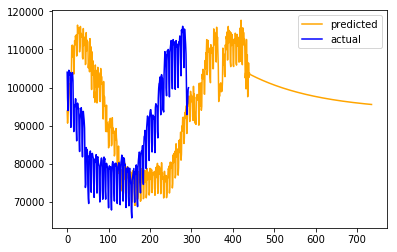

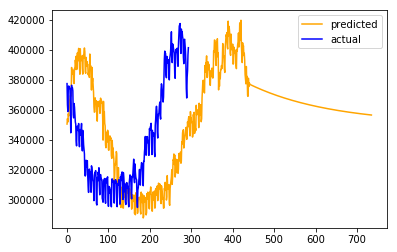

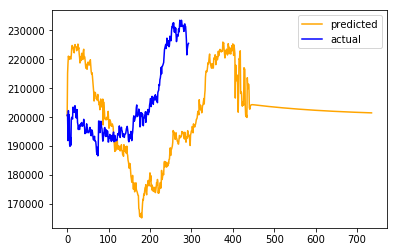

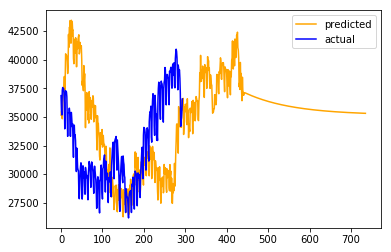

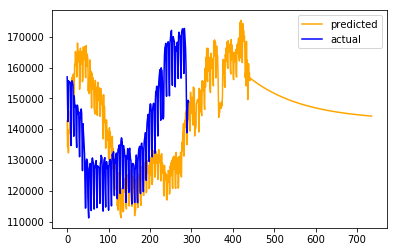

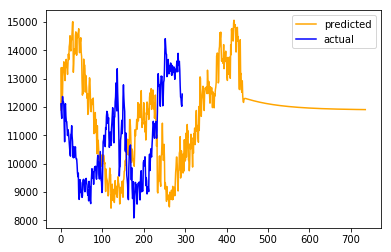

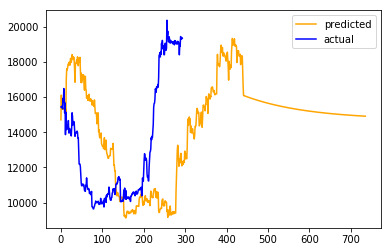

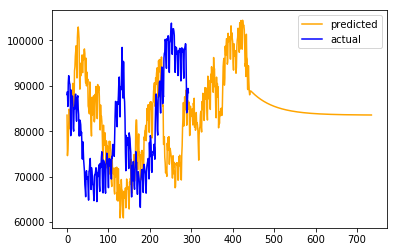

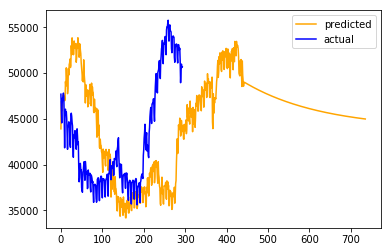

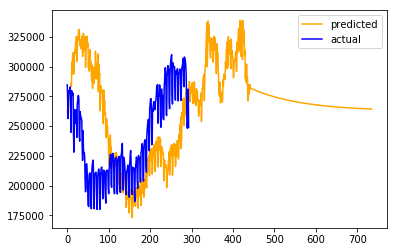

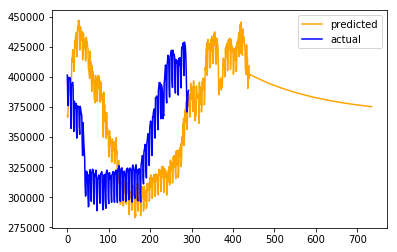

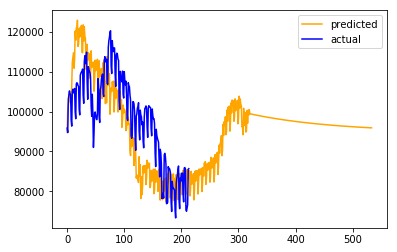

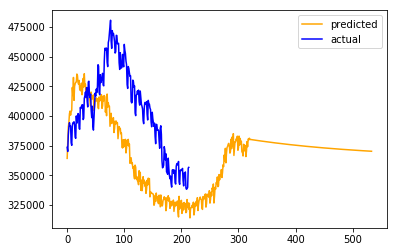

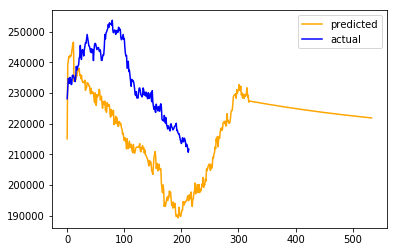

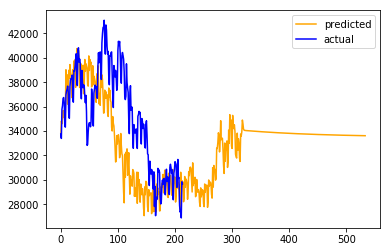

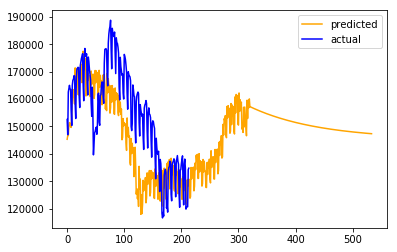

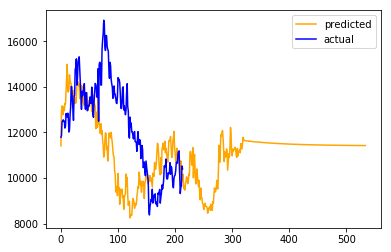

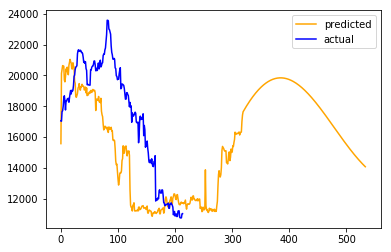

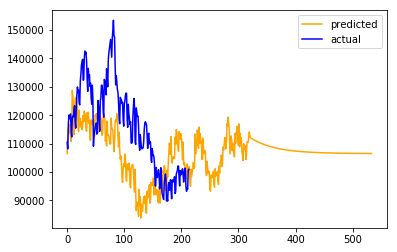

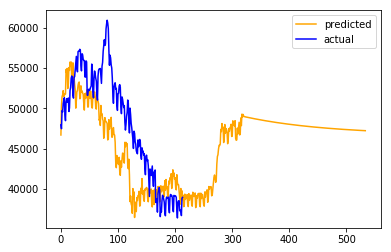

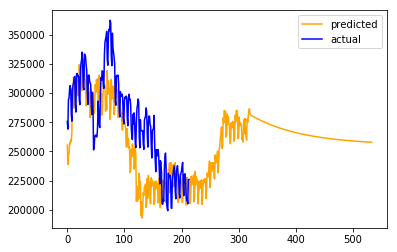

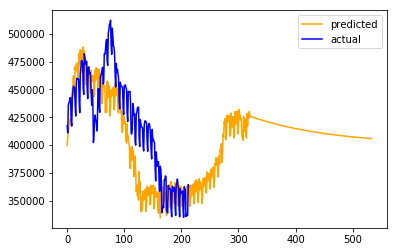

In [77]:
for i in range(len(v_pred)):
    plt.plot(v_pred[i], color="orange")
    plt.plot(v_actual[i], color="blue")
    plt.legend(["predicted", "actual"])
    plt.show()